Read data from the PMS over serial. I want to convert the keys using the following mapping:

In [1]:
key_map = {
    "a":"particles_03um",
    "b":"particles_05um",
    "c":"particles_10um",
    "d":"particles_25um",
    "e":"particles_50um",
    "f":"particles_100um"
}

In [2]:
import serial
import time
import datetime
import json
import pandas as pd
%matplotlib inline

In [3]:
!ls /dev/tty.*

/dev/tty.Bluedio-BluetoothSerial /dev/tty.RobinsiPhone6-Wirelessi
/dev/tty.Bluetooth-Incoming-Port /dev/tty.usbmodem141401


In [4]:
port = '/dev/tty.usbmodem141401'

In [5]:
ser = serial.Serial(port)

In [6]:
data_json = ser.readline().decode("utf-8").replace("\r\n", "") 

In [7]:
data_dict = json.loads(data_json)

In [8]:
data_dict

{'a': 1155, 'b': 322, 'c': 29, 'd': 1, 'e': 0, 'f': 0}

Use the key map to recover accurate keys

In [9]:
mapped_data_dict = {key_map[key]:val for key, val in data_dict.items()}

In [10]:
mapped_data_dict

{'particles_03um': 1155,
 'particles_05um': 322,
 'particles_10um': 29,
 'particles_25um': 1,
 'particles_50um': 0,
 'particles_100um': 0}

In [11]:
pd.Series(mapped_data_dict)

particles_03um     1155
particles_05um      322
particles_10um       29
particles_25um        1
particles_50um        0
particles_100um       0
dtype: int64

Lets wrap this in a small class

In [50]:
class pmsreader():
    def __init__(self, port='/dev/tty.usbmodem141401'):
        self._ser = serial.Serial(port)
    
    def read(self):
        try:
            data_json = self._ser.readline().decode("utf-8").replace("\r\n", "") 
            data_dict = json.loads(data_json)
            mapped_data_dict = {key_map[key]:val for key, val in data_dict.items()}
            mapped_data_dict['time'] = datetime.datetime.now()
            return mapped_data_dict
        except:
            return None        

In [51]:
pms = pmsreader()

In [52]:
pms.read()

{'particles_03um': 1155,
 'particles_05um': 348,
 'particles_10um': 39,
 'particles_25um': 4,
 'particles_50um': 3,
 'particles_100um': 1,
 'time': datetime.datetime(2018, 10, 31, 7, 18, 3, 299568)}

Now capture some time-series data

In [60]:
data = []
measurements = 30
sleep_sec = 2

for i in range(measurements):
    reading = pms.read()
    if reading is not None:
        data.append(reading)
    time.sleep(sleep_sec)

In [61]:
df = pd.DataFrame(data)
df.set_index('time', inplace=True)

In [62]:
df.head()

,particles_03um,particles_05um,particles_100um,particles_10um,particles_25um,particles_50um
time,,,,,,
2018-10-31 07:23:42.184571,1065,319,0,32,5,5
2018-10-31 07:23:44.186738,1065,319,0,32,5,5
2018-10-31 07:23:46.191700,1065,320,0,36,6,6
2018-10-31 07:23:48.196116,1065,320,0,36,6,6
2018-10-31 07:23:50.197537,1065,320,0,36,6,6


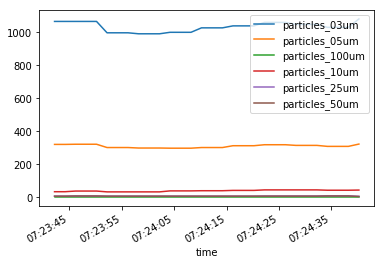

In [63]:
df.plot()